# Hypothyroid Disease Classification
### Group 17: Matthew Gillies, Ryan Lee, Eric Liu, Arman Moztarzadeh

## Summary

## Introduction

## Methods and Results

In [82]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')

In [ ]:
if not os.path.exists("data"):
    os.makedirs("data")
path1 = 'http://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/allhyper.data'
path2 = 'http://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/allhyper.test'
columnNames = ["age", "sex", "on thyroxine", "query on thyroxine",
               "on antithyroid medication", "sick", "pregnant",
               "thyroid surgery", "I131 treatment", "query hypothyroid",
               "query hyperthyroid", "lithium", "goitre", "tumor",
               "hypopituitary", "psych", "TSH measured", "TSH", "T3 measured",
               "T3", "TT4 measured", "TT4", "T4U measured", "T4U",
               "FTI measured", "FTI", "TBG measured", "TBG", "referral source",
               "binary class"]
dfData = pd.read_csv(path1, names=columnNames)
dfTest = pd.read_csv(path2, names=columnNames)
hypothyroid_df = pd.concat([dfData, dfTest])


In [ ]:
for row in range(len(df)):
    if (df['binary class'].values[row][0] == "n"):
        df['binary class'].values[row] = "P"
    if (df['binary class'].values[row][0] == "h"):
        df['binary class'].values[row] = "N"
hypothyroid_df.to_csv('data/hypothyroid.csv')

In [59]:
## Reading in data
#hypothyroid_df = pd.read_csv("data/hypothyroid.csv")
hypothyroid_df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,P


In [60]:
hypothyroid_df.shape

(3772, 30)

In [61]:
## Replacing ? values with NA
hypothyroid = hypothyroid_df.replace("?", np.nan)

In [62]:
hypothyroid.isna().sum()

age                             1
sex                           150
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           369
T3 measured                     0
T3                            769
TT4 measured                    0
TT4                           231
T4U measured                    0
T4U                           387
FTI measured                    0
FTI                           385
TBG measured                    0
TBG                          3772
referral source                 0
binaryClass   

In [63]:
## **** Not sure if we want to drop NA's or impute?
## Due to large amount of NA values in TBG and T3 these features will be removed from the dataset. 
## All "measured" features will also be removed as once NA's are removed they will all be "t"
## We will also removed the referral source column as it is quite irrelevant
## All other NA rows will simply be dropped
hypo = hypothyroid.drop(columns = ["TBG", "TBG measured", "T3", "T3 measured", "TSH measured", "TT4 measured", "FTI measured"
                                   , "T4U measured", "referral source"])

In [64]:
hypo_clean = hypo.dropna()

In [65]:
hypo_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3103 entries, 0 to 3771
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3103 non-null   object
 1   sex                        3103 non-null   object
 2   on thyroxine               3103 non-null   object
 3   query on thyroxine         3103 non-null   object
 4   on antithyroid medication  3103 non-null   object
 5   sick                       3103 non-null   object
 6   pregnant                   3103 non-null   object
 7   thyroid surgery            3103 non-null   object
 8   I131 treatment             3103 non-null   object
 9   query hypothyroid          3103 non-null   object
 10  query hyperthyroid         3103 non-null   object
 11  lithium                    3103 non-null   object
 12  goitre                     3103 non-null   object
 13  tumor                      3103 non-null   object
 14  hypopitu

In [66]:
## Changing Dtype of the columns to numeric/categorical 
num_cols = ['age', 'TSH', 'TT4', 'T4U', 'FTI']
cat_cols = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
            'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'psych', 'binaryClass',
           'hypopituitary']
hypo_clean[num_cols] = hypo_clean[num_cols].apply(pd.to_numeric, errors='coerce', axis=1)
for col in cat_cols:
    hypo_clean[col] = hypo_clean[col].astype('category')

In [67]:
## Changing binaryClass so 0 represents negative and 1 represents positive
hypo_clean['binaryClass'] = hypo_clean['binaryClass'].replace(["N", "P"], [0,1])

In [68]:
hypo_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3103 entries, 0 to 3771
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        3103 non-null   float64 
 1   sex                        3103 non-null   category
 2   on thyroxine               3103 non-null   category
 3   query on thyroxine         3103 non-null   category
 4   on antithyroid medication  3103 non-null   category
 5   sick                       3103 non-null   category
 6   pregnant                   3103 non-null   category
 7   thyroid surgery            3103 non-null   category
 8   I131 treatment             3103 non-null   category
 9   query hypothyroid          3103 non-null   category
 10  query hyperthyroid         3103 non-null   category
 11  lithium                    3103 non-null   category
 12  goitre                     3103 non-null   category
 13  tumor                      3103 n

Figure 1: Correlations of numeric features


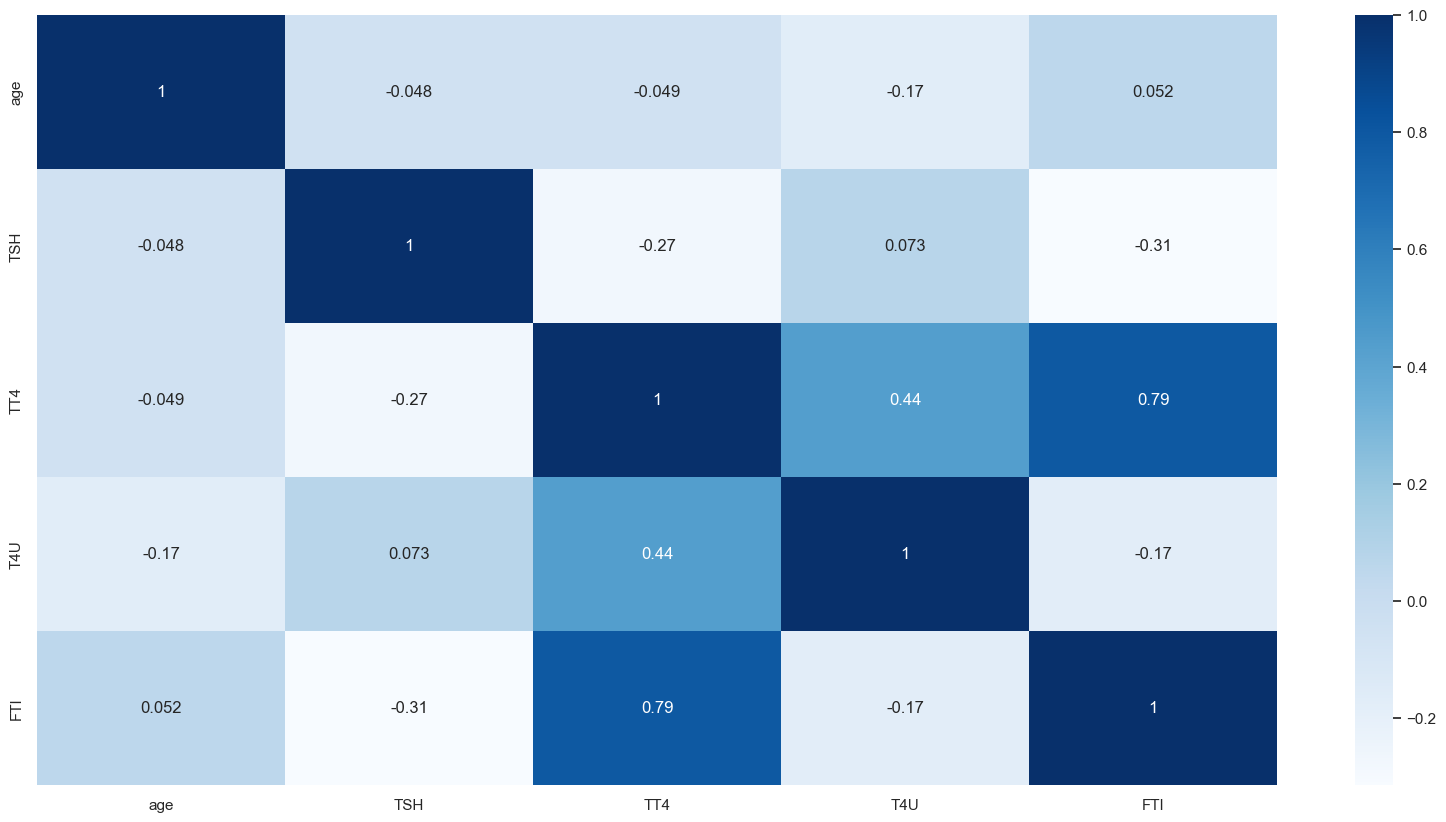

In [69]:
## Visualizing correlations of numeric features
print("Figure 1: Correlations of numeric features")
numeric = hypo_clean[['age', 'TSH', 'TT4', 'T4U', 'FTI']]
cor = numeric.corr()
plt.figure(figsize=(20, 10))
sn.set(font_scale=1)
sn.heatmap(cor, annot=True, cmap=plt.cm.Blues);

In [70]:
print("Figure 2: Realization of class counts")
pd.DataFrame(hypo_clean['binaryClass'].value_counts())

Figure 2: Realization of class counts


,binaryClass
1,2845
0,258


In [71]:
## Splitting data
X = hypo_clean.drop(columns = "binaryClass")
y = hypo_clean['binaryClass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,TT4,T4U,FTI
2414,70.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,5.5,131.0,1.49,88.0
2231,41.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,2.0,110.0,1.14,97.0
868,13.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,2.9,113.0,1.23,92.0
749,63.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,4.5,93.0,0.87,107.0
2632,47.0,F,f,f,f,t,f,f,f,f,f,f,f,f,f,f,1.7,91.0,0.96,94.0


In [72]:
## Preprocessing data
onehot = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
            'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'psych',
           'hypopituitary']
numeric = ['age', 'TSH', 'TT4', 'T4U', 'FTI']

In [73]:
ct = make_column_transformer(
    (StandardScaler(), numeric), 
    (OneHotEncoder(handle_unknown = 'ignore'), onehot)
)

In [74]:
transformed_X_train = ct.fit_transform(X_train)
transformed_X_test = ct.transform(X_test)
transformed_X_test

array([[ 0.82329878,  0.0473449 ,  0.46166102, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.33803285, -0.03509786, -0.19509205, ...,  0.        ,
         1.        ,  0.        ],
       [-0.05017989,  1.60551314, -1.19449891, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.87182538, -0.01448717, -0.42352791, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.28950626,  0.01848993, -0.88039962, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.96887856,  0.20398615, -0.68051824, ...,  0.        ,
         1.        ,  0.        ]])

In [75]:
## Creating LogisticRegression Classifier
pipe_log = make_pipeline(ct, LogisticRegression(max_iter = 1000, C = 1))
cv = cross_validate(pipe_log, X_train, y_train)
pd.DataFrame(cv)

,fit_time,score_time,test_score
0,0.049601,0.004830,0.956322
1,0.035930,0.004996,0.949425
2,0.035912,0.005453,0.953917
3,0.039666,0.004607,0.933180
4,0.037352,0.004687,0.958525


Cross validation performs well so this model will be applied to the dataset.

In [76]:
lr = LogisticRegression(max_iter = 1000, C = 1)
X_train_trans = ct.fit_transform(X_train)
X_test_trans = ct.transform(X_test)
lr.fit(X_train_trans, y_train)
train_preds = lr.predict(X_train_trans)

Figure 3: Visualization of Classification with TSH and TT4 concentration on the axes for training set


Text(0, 0.5, 'TT4 concentration')

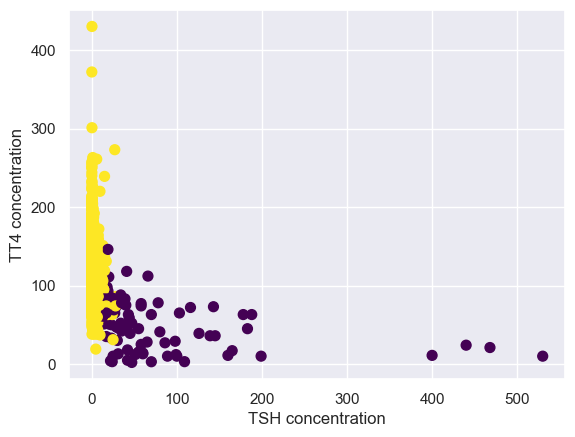

In [77]:
print("Figure 3: Visualization of Classification with TSH and TT4 concentration on the axes for training set")
plt.scatter(X_train["TSH"], X_train["TT4"], c=train_preds, s=50, cmap='viridis')
plt.xlabel("TSH concentration")
plt.ylabel("TT4 concentration")


In [78]:
accuracy_score(train_preds, y_train)

0.9530386740331491

The model produces a very strong 96% accuracy rate on the training data. 

In [79]:
## Test set
test_preds = lr.predict(X_test_trans)

Figure 4: Visualization of Clusters with TSH and TT4 concentration on the axes for test set


Text(0, 0.5, 'TT4 concentration')

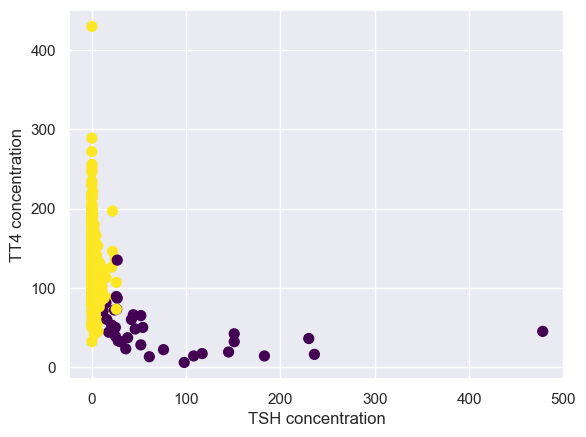

In [80]:
print("Figure 4: Visualization of Clusters with TSH and TT4 concentration on the axes for test set")
plt.scatter(X_test["TSH"], X_test["TT4"], c=test_preds, s=50, cmap='viridis')
plt.xlabel("TSH concentration")
plt.ylabel("TT4 concentration")

In [81]:
accuracy_score(test_preds, y_test)

0.9602577873254565

The model also performs quite well on the test set with a 95% accuracy.

In [85]:
## Confusion Matrix
print("Figure 5: Confusion matrix for test predictions")
pd.DataFrame(confusion_matrix(y_test, test_preds))

Figure 5: Confusion matrix for test predictions


,0,1
0,35,36
1,1,859


It appears that most of our incorrect predictions are false positives, which are better in this case as we would rather incorrectly diagnose someone to have hypothyroid disease than incorrectly diagnose someone as disease free. 

## Discussion

## References